### A.9.3 Training with multiple GPUs

Distributed training is the concept of dividing the model training across multiple GPUs and machines. Why do we need this? Even when it is possible to train a model on a single GPU or machine, the process could be exceedingly time-consuming. The training time can be significantly reduced by distributing the training process across multiple machines, each with potentially multiple GPUs. This is particularly crucial in the experimental stages of model development, where numerous training iterations might be necessary to fine-tune the model parameters and architecture.

Let’s begin with the most basic case of distributed training: PyTorch’s `DistributedDataParallel (DDP)` strategy. DDP enables parallelism by splitting the input data across the available devices and processing these data subsets simultaneously.

How does this work? PyTorch launches a separate process on each GPU, and each process receives and keeps a copy of the model; these copies will be synchronised during training. To illustrate this, suppose we have two GPUs that we want to use to train a neural network, as shown in figure below:

In [5]:
from pathlib import Path
import subprocess
from loguru import logger


def git_codebase_root():
    try:
        root = subprocess.check_output(
            ["git", "rev-parse", "--show-toplevel"], stderr=subprocess.DEVNULL
        )
        return Path(root.decode().strip())
    except subprocess.CalledProcessError:
        logger.warning("Not inside a Git repository.")
        return None

def get_working_directory_or_git_root():
    git_root = git_codebase_root()
    return git_root if git_root is not None else Path.cwd()

root_dir = get_working_directory_or_git_root()
#print(root_dir)

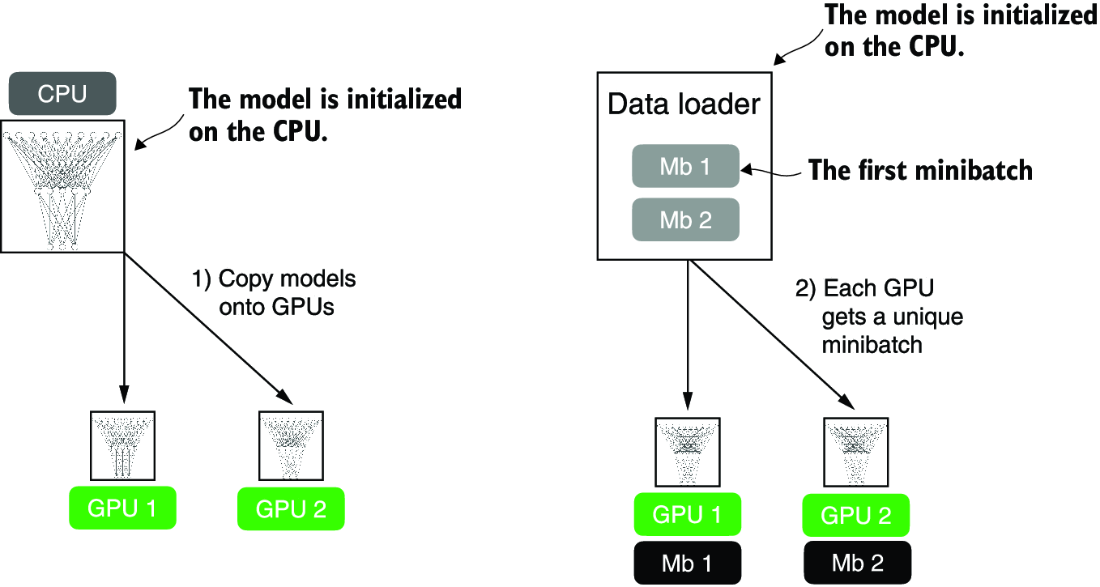

In [6]:
from IPython.display import Image
Image(root_dir/ "docs/images/training_with_multiple_gpus.png")

The model and data transfer in DDP involves two key steps:

 - First, we create a copy of the model on each of the GPUs.
  - Then we divide the input data into unique minibatches that we pass on to each model copy.



Each of the two GPUs will receive a copy of the model. Then, in every training iteration, each model will receive a minibatch (or just “batch”) from the data loader. We can use a `DistributedSampler` to ensure that each GPU will receive a different, non-overlapping batch when using DDP.

Since each model copy will see a different sample of the training data, the model copies will return different logits as outputs and compute different gradients during the backward pass. These gradients are then **averaged** and synchronised during training to update the models. This way, we ensure that the models don’t diverge, as illustrated in figure below:

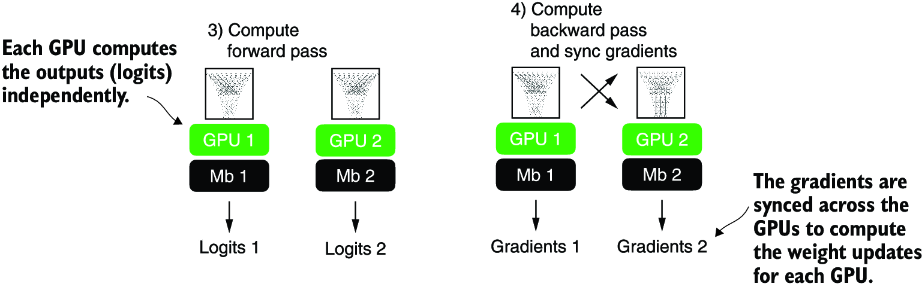

In [7]:
Image(root_dir/ "docs/images/forward_and_backward_passes_in_DDP.png")

The forward and backward passes in DDP are executed independently on each GPU with its corresponding data subset. Once the forward and backward passes are completed, gradients from each model replica (on each GPU) are synchronised across all GPUs. This ensures that every model replica has the same updated weights.

The benefit of using DDP is the enhanced speed it offers for processing the dataset compared to a single GPU. Barring a minor communication overhead between devices that comes with DDP use, it can theoretically process a training epoch in half the time with two GPUs compared to just one. The time efficiency scales up with the number of GPUs, allowing us to process an epoch eight times faster if we have eight GPUs, and so on.

NOTE:

DDP does not function properly within interactive Python environments like Jupyter notebooks, which don’t handle multiprocessing in the same way a standalone Python script does. Therefore, the following code should be executed as a script, not within a notebook interface like Jupyter.

**DDP needs to spawn multiple processes, and each process should have its own Python interpreter instance.**

First, we import a few additional submodules, classes, and functions for distributed training PyTorch, as shown in the following listing.

In [8]:
import torch.multiprocessing as mp
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import init_process_group, destroy_process_group

torch.multiprocessing as mp --> PyTorch’s `multiprocessing` submodule contains functions such as `multiprocessing.spawn`, which we will use to spawn multiple processes and apply a function to multiple inputs in parallel. We will use it to spawn one training process per GPU. If we spawn multiple processes for training, we will need a way to divide the dataset among these different processes. For this, we will use the `DistributedSampler`.

torch.multiprocessing.spawn -->
- Creates separate processes for each GPU
- Each process gets a unique 'rank' (like an ID number)
- Handles process management and communication

DistributedSampler -->
- Divides dataset among processes
- Ensures no overlap in data between processes
- Handles shuffling while maintaining distribution

The process works like this:

1. mp.spawn creates separate processes
2. Each process:

    - Gets assigned a GPU
    - Gets its portion of the data via DistributedSampler
    - Trains on its data subset
    - Synchronizes gradients with other processes


`init_process_group` and `destroy_process_group` are used to initialise and quit the distributed training mods. The `init_process_group` function should be called at the beginning of the training script to initialise a process group for each process in the distributed setup, and `destroy_process_group` should be called at the end of the training script to destroy a given process group and release its resources.

The process is similar to:

1. Starting a meeting (init_process_group):

    - Everyone joins the same virtual room
    - Each person gets a unique ID
    - Communication rules are established


2. During the meeting (training):

    - Everyone can communicate and share information
    - Work is coordinated and synchronized
    - Resources are shared efficiently


3. Ending the meeting (destroy_process_group):

    - Communication channels are closed
    - Resources are freed
    - Everything is cleaned up properly